我们还需要一点基础性的工作，在特征构建的时候，除了日内的短周期价格信息以外，我们希望直接在特征上编码一个长周期的信息用于建模。

虽然有很多模型可以处理长序列问题，但是长序列的信息有效传递仍然是制约时序模型的重要因素。

与其让模型学习如何传递那些长距离信息，不如直接将一些我们已经知道大概率会有价值的长距离信息直接编码进来

参考价格信息，即移动平均，或者价格相对于历史价格的变动，在历史回望周期内的相对位置等等这些信息已经被技术分析证明是有效的，或者作为底层信息用于其他指标。

此外，在patch子序列的时候，我们也需要调整子序列的长度

我们可以把周期长度和子序列长度作为超参数，在模型层面进行调整，但这样的效率比较低，也不够直观

In [30]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

from scipy.signal import find_peaks
from scipy.stats import chi2

# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False


一个更好的方式是应用傅里叶变换，从价格数据上找到重要的频域，在根据这些频域对应的周期构建相关的模型。

由于傅里叶变换假定原序列是由多个周期信号叠加成的平稳序列，我们需要对原价格数据进行一阶差分

短周期的信息可以直接在patch内，或者通过RNN完成信息传递和建模，我们希望关注的是那些在10天以上，通过序列传递比较困难的长周期信息：

In [31]:
def fft_analyse(series, plot = False):
    # 计算fft
    N = len(series)
    # window = np.hanning(N)
    # series = series * window 
    fft_values = np.fft.fft(series)
    frequencies = np.fft.fftfreq(N, d=1)
    # 抽取周期和振幅
    positive_mask = frequencies > 0
    fft_values_pos = fft_values[positive_mask]
    frequencies_pos = frequencies[positive_mask]
    periods = 1 / frequencies_pos
    amplitudes = np.abs(fft_values_pos) * 2 / N
    # 划分为整数周期，并取周期内最强振幅为周期的振幅
    int_periods = periods.astype(int)
    df = pd.DataFrame({'period': int_periods,'amplitude': amplitudes,})
    max_weights_series = df.groupby('period')['amplitude'].max()
    max_val = max_weights_series.index.max()
    result_weights = np.zeros(max_val + 1)
    result_weights[max_weights_series.index] = max_weights_series.values

    short_periods = result_weights[5:60]
    long_periods = result_weights[40:250]
    # 作图
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.bar(np.arange(5,60), short_periods)
        ax1.set_title('Short Periods')
        ax1.set_xlabel('Days')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True, alpha=0.3)
        ax2.bar(np.arange(40,250), long_periods)
        ax2.set_title('Long Periods')
        ax2.set_xlabel('Days')
        ax2.set_ylabel('Amplitude')
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return result_weights

首先，我们分析数据的平稳性，对比2015-2020 和2020-205两个时间段内，周期性是否发生了概念漂移

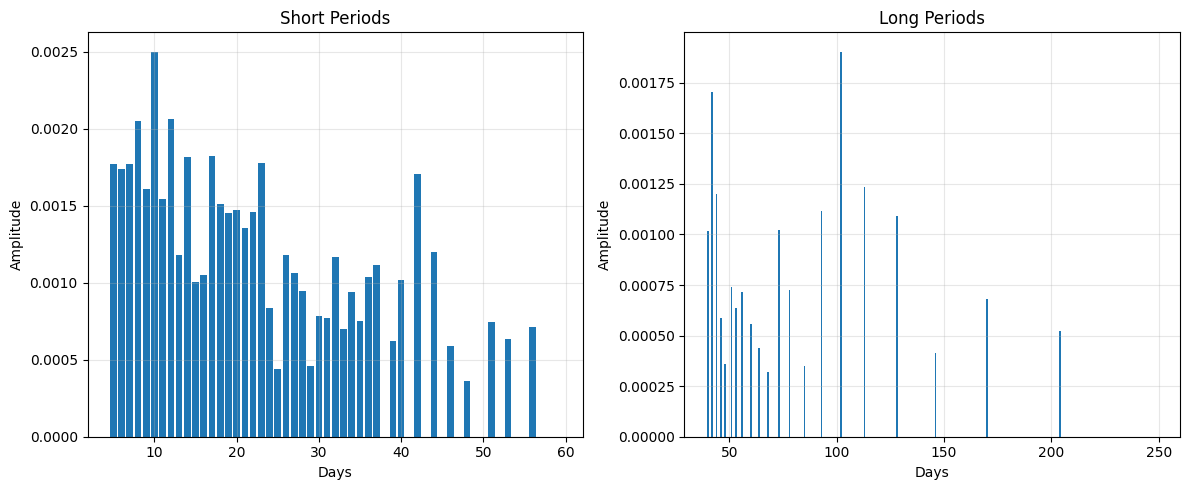

In [32]:
# 2015-2020
data_1 = pro.fut_daily(ts_code = 'IH.CFX', start_date = '201500101', end_date = '20200101',fields = 'pre_close, close').dropna()[-1024:] # 对齐序列长度以便模型在长周期区域具有可比性
price_1 = detrend(np.log(data_1['close']))
price_diff_1 = detrend(np.log(data_1['close']) - np.log(data_1['pre_close']))
result_weights = fft_analyse(price_diff_1, plot=True)

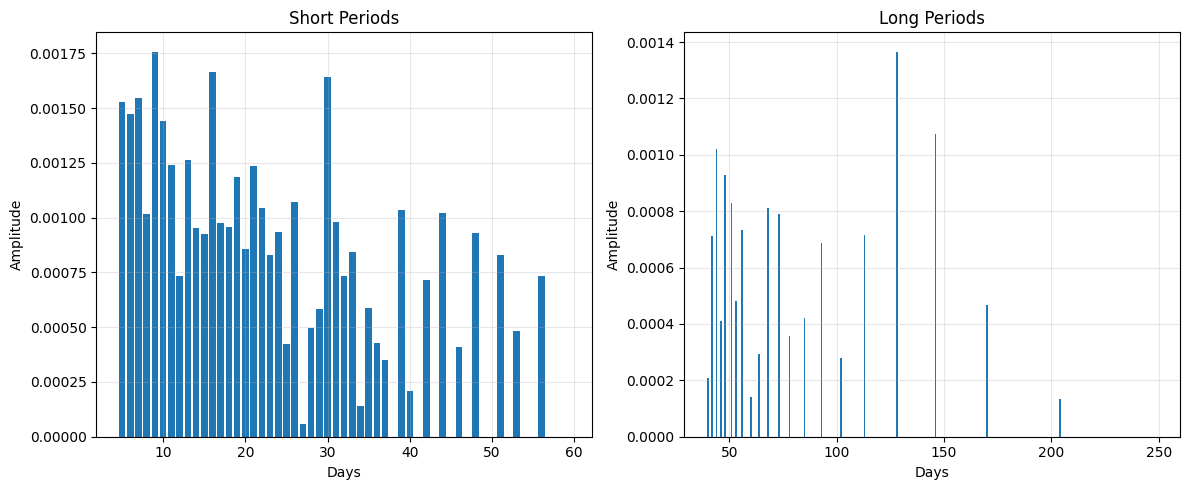

In [33]:
# 2020-2025
data_2 = pro.fut_daily(ts_code = 'IH.CFX', start_date = '202000101', end_date = '20250101',fields = 'pre_close, close').dropna()[-1024:] # 对齐序列长度以便模型在长周期区域具有可比性
price_2 = detrend(np.log(data_2['close']))
price_diff_2 = detrend(np.log(data_2['close']) - np.log(data_2['pre_close']))
result_weights = fft_analyse(price_diff_2, plot=True)

整体来说，短周期的振幅偏高，随着周期增长噪声呈现下降趋势，（如果直接应用原始价格则相反）

不同周期的相对强弱发生了漂移，例如30日周期、150日周期 或许暗示我们使用更复杂的工具。这里我们

In [34]:
def periods_significance(series, significance_level=0.95):

    N = len(series)
    lag1_corr = np.corrcoef(series[:-1], series[1:])[0, 1]
    fft_values = np.fft.fft(series)
    frequencies = np.fft.fftfreq(N, d=1)

    positive_mask = frequencies > 0
    fft_values_pos = fft_values[positive_mask]
    frequencies_pos = frequencies[positive_mask]
    periods = 1 / frequencies_pos
    amplitudes = np.abs(fft_values_pos) * 2 / N
    psd = amplitudes**2

    noise_spectrum = (1 - lag1_corr**2) / (1 - 2 * lag1_corr * np.cos(2 * np.pi * frequencies_pos) + lag1_corr**2)
    scaled_noise_spectrum = noise_spectrum * np.mean(psd) / np.mean(noise_spectrum)
    chi2_factor = chi2.ppf(significance_level, df=2) / 2
    confidence_limit = scaled_noise_spectrum * chi2_factor
    all_peaks = find_peaks(psd)[0]
    significant_peak_indices = [p for p in all_peaks if psd[p] > confidence_limit[p]]
    
    peak_power = psd[significant_peak_indices]
    peak_limit = confidence_limit[significant_peak_indices]
    peak_significance = peak_power / peak_limit
    sorted_indices = np.argsort(peak_significance)[::-1]

    for i, idx in enumerate(sorted_indices):
        original_idx = significant_peak_indices[idx]
        if periods[original_idx]>5:
            print(f"period: {periods[original_idx]:<13.2f}  significance: {peak_significance[idx]:.2f}")

In [35]:
periods_significance(price_1, significance_level=0.9)

period: 10.04          significance: 1.70
period: 7.64           significance: 1.56
period: 102.40         significance: 1.41
period: 8.61           significance: 1.41
period: 6.48           significance: 1.11
period: 19.69          significance: 1.10
period: 10.24          significance: 1.07
period: 18.96          significance: 1.02
period: 5.75           significance: 1.02


In [36]:
periods_significance(price_2, significance_level=0.9)

period: 9.39           significance: 1.64
period: 16.52          significance: 1.59
period: 7.16           significance: 1.46
period: 6.61           significance: 1.19
period: 10.24          significance: 1.15
period: 10.89          significance: 1.12
period: 5.51           significance: 1.11
period: 30.12          significance: 1.11
period: 128.00         significance: 1.11
period: 5.36           significance: 1.09
period: 21.79          significance: 1.08


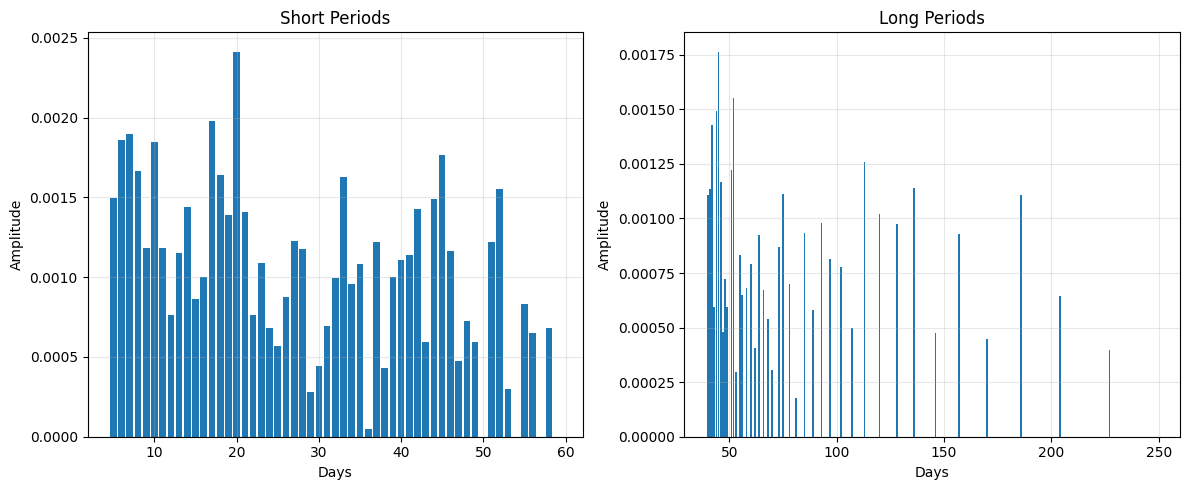

In [37]:
assets_code = 'IC.CFX'
data_1 = pro.fut_daily(ts_code = assets_code, start_date = '20150101', end_date = '20210101',fields = 'pre_close, close')
data_2 = pro.fut_daily(ts_code = assets_code, start_date = '20210101', fields = 'pre_close, close')
data = pd.concat([data_1, data_2], ignore_index = True).dropna()[-2048:]
price_diff = detrend(np.log(data['close']) - np.log(data['pre_close']))
result_weights = fft_analyse(price_diff, plot=True)

与IH相关性较强的IC：高频短波周期比较接近，可以看到10, 20, 45等一些比较相似的关系；

长度变动比较大，但也可以观察到45天左右的短周期和135天位置的一个长周期关系

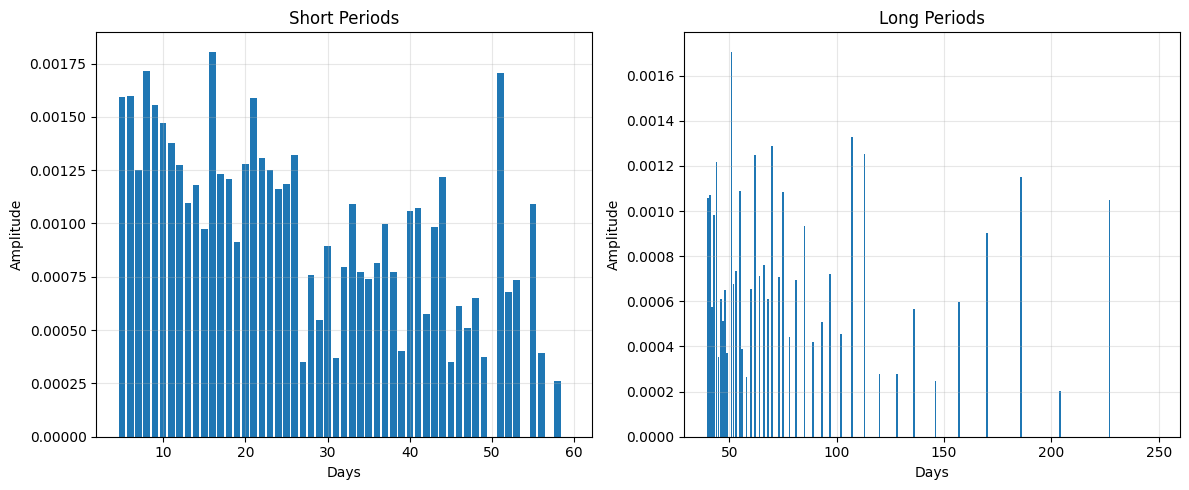

In [38]:
assets_code = 'RB.SHF'
data_1 = pro.fut_daily(ts_code = assets_code, start_date = '20150101', end_date = '20210101',fields = 'pre_close, close')
data_2 = pro.fut_daily(ts_code = assets_code, start_date = '20210101', fields = 'pre_close, close')
data = pd.concat([data_1, data_2], ignore_index = True).dropna()[-2048:]
price_diff = detrend(np.log(data['close']) - np.log(data['pre_close']))
result_weights = fft_analyse(price_diff, plot=True)

再分析与关系更远的商品期货，总体仍保持高频区域振幅大的特点。部分周期如45天仍然强势存在，短周期和长周期的振幅形态发生了一定的变化，或许暗示周期性既有跨资产的一般性，也有资产内的独立性

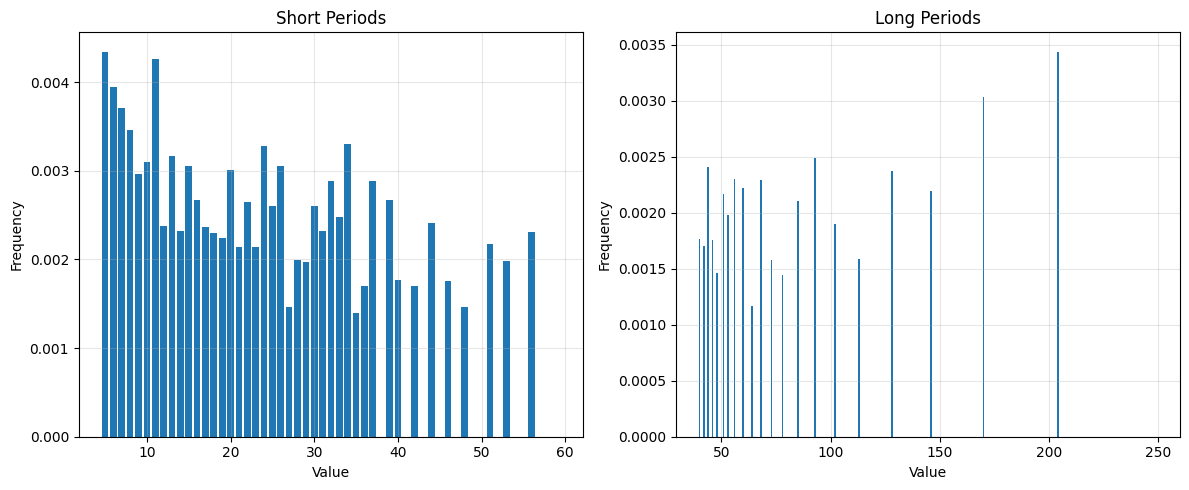

In [39]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'FU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
cross_weight = np.zeros(shape = (250,))
for assets_code in assets_list:
    data = pro.fut_daily(ts_code = assets_code, start_date = '20200101', fields = 'pre_close, close').dropna()[-1024:]
    price_diff = detrend(np.log(data['close']) - np.log(data['pre_close']))
    result_weights = fft_analyse(price_diff, plot=False)[:250]
    cross_weight = np.maximum(cross_weight, result_weights)
        
short_periods = cross_weight[5:60]
long_periods = cross_weight[40:250]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(np.arange(5,60), short_periods)
ax1.set_title('Short Periods')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)
ax2.bar(np.arange(40,250), long_periods)
ax2.set_title('Long Periods')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

短周期层面，不同资产的频域分布比较接近，10, 16, 22, 25， 27都有比较相似的分布，或许暗示短周期主要是受与基本面无关的技术面因素影响。

而长周期则呈现资产关联的特点，例如同为股指期货的IH IF IC 都有45, 101, 和115的强势周期

同为黑色系的I RB HC则都有 70和 190 的周期，暗示着长周期主要受资产的基本面影响，

我们将不同资产合并之后，发现各个周期的强度开始趋同，不再具有明显特征，这可能是不同资产的周期性存在差异，导致合并之后原来的周期性因素被掩盖了。

（由于fft的离散性特点，频率接近的波很有可能是同一个关系的分量，所以43和45可以看作是近似一致的）

分析跨时间的关系, 只看近5年的观察是否发生模式的偏移



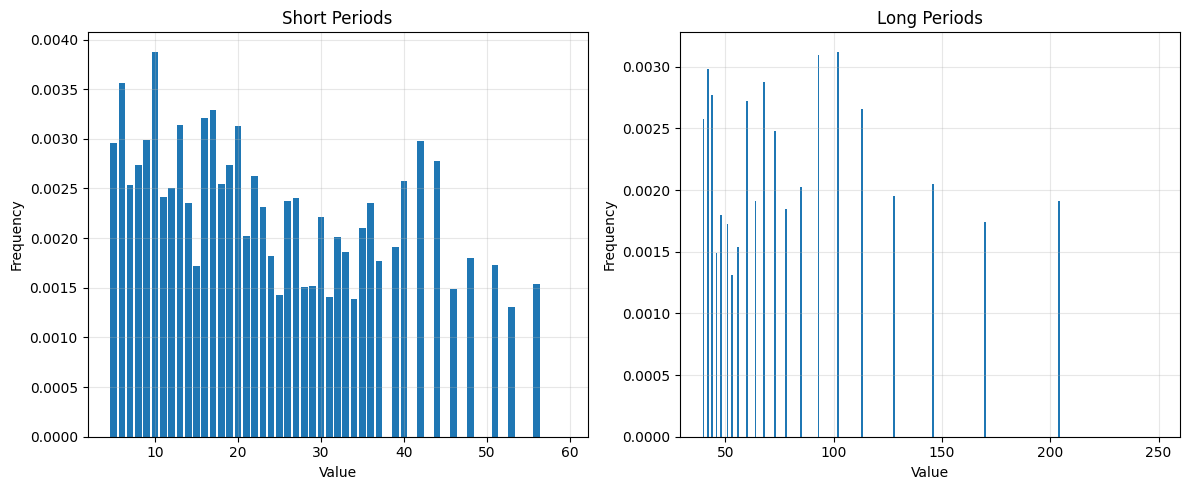

In [40]:
# 2015 - 2020
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'FU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
cross_weight = np.zeros(shape = (250,))
for assets_code in assets_list:
    data = pro.fut_daily(ts_code = assets_code, start_date = '20150101', end_date = '20200101', fields = 'pre_close, close').dropna()[-1024:]
    price_diff = detrend(np.log(data['close']) - np.log(data['pre_close']))
    result_weights = fft_analyse(price_diff, plot=False)[:250]
    cross_weight = np.maximum(cross_weight, result_weights)
        
short_periods = cross_weight[5:60]
long_periods = cross_weight[40:250]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(np.arange(5,60), short_periods)
ax1.set_title('Short Periods')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)
ax2.bar(np.arange(40,250), long_periods)
ax2.set_title('Long Periods')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

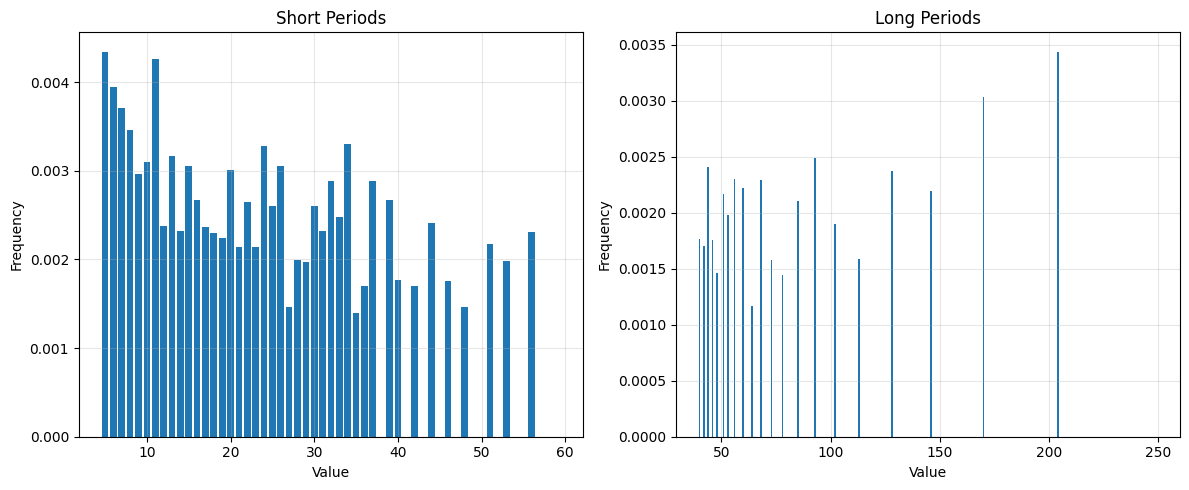

In [41]:
# 2015 - 2020
cross_weight = np.zeros(shape = (250,))
for assets_code in assets_list:
    data = pro.fut_daily(ts_code = assets_code, start_date = '20200101', end_date = '20250101', fields = 'pre_close, close').dropna()[-1024:]
    price_diff = detrend(np.log(data['close']) - np.log(data['pre_close']))
    result_weights = fft_analyse(price_diff, plot=False)[:250]
    cross_weight = np.maximum(cross_weight, result_weights)
        
short_periods = cross_weight[5:60]
long_periods = cross_weight[40:250]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(np.arange(5,60), short_periods)
ax1.set_title('Short Periods')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)
ax2.bar(np.arange(40,250), long_periods)
ax2.set_title('Long Periods')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

可以看到，长周期的振幅发生了偏移。这或许提示我们，历史序列不能选取太久，否则模型就会被模式迁移所影响。

短周期的迁移则不是很明显，可能是因为技术层面的驱动因素并没有受到基本面的影响。